# Flat Gaussian with compositional score matching


In this notebook, we will use the compositional score matching to learn the posterior of a flat Gaussian model.
The problem is defined as follows:
- The prior is a Gaussian distribution with mean 0 and standard deviation 0.1.
- The simulator/likelihood is a Gaussian distribution with mean 0 and standard deviation 0.1.
- We have an analytical solution for the posterior.
- We set the dimension of the problem to $D=10$.

In [1]:
import ast
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics
from torch.utils.data import DataLoader

from diffusion_model import CompositionalScoreModel, SDE, weighting_function, train_score_model, sde_sampling, \
    adaptive_sampling, probability_ode_solving, langevin_sampling, generate_diffusion_time, count_parameters
from problems.gaussian_flat import GaussianProblem, Prior, Simulator, visualize_simulation_output, \
    generate_synthetic_data, \
    sample_posterior, analytical_posterior_mean_std, posterior_contraction

In [2]:
torch_device = torch.device("cpu")

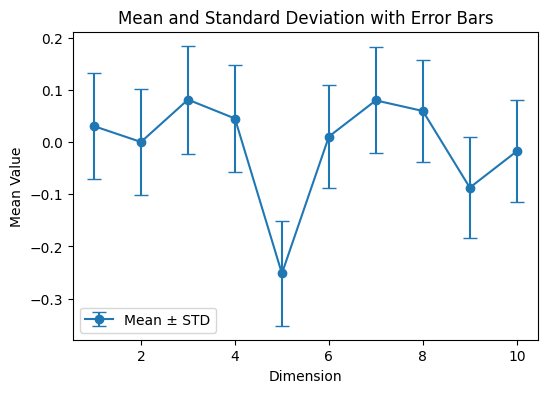

In [3]:
prior = Prior()
simulator_test = Simulator()

# test the simulator
prior_test = prior.sample(2)
sim_test = simulator_test(prior_test, n_obs=1000)
visualize_simulation_output(sim_test['observable'])

In [5]:
batch_size = 128
max_number_of_obs = 1  # larger than one means we condition the score on multiple observations

dataset = GaussianProblem(
    n_data=10000,
    prior=prior,
    online_learning=True,
    max_number_of_obs=max_number_of_obs
)
dataset_valid = GaussianProblem(
    n_data=batch_size*2,
    prior=prior,
    max_number_of_obs=max_number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [6]:
# Define diffusion model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1]
)

score_model = CompositionalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_x=prior.D,
    hidden_dim=64,
    n_blocks=3,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    use_film=False,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior
)
#score_model.name = score_model.name + '_same_sim_budget'
count_parameters(score_model)
print(score_model.name)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

Kernel type: variance_preserving, noise schedule: cosine
t_min: 0.00035210439818911254, t_max: 0.9957104921340942
alpha, sigma: (tensor(1.0000), tensor(0.0011)) (tensor(0.0134), tensor(0.9999))
+------------------------------------+------------+
|              Modules               | Parameters |
+------------------------------------+------------+
|        summary_net.0.weight        |    640     |
|         summary_net.0.bias         |     64     |
|     global_model.embed.0.scale     |     1      |
|    global_model.embed.1.weight     |    256     |
|     global_model.embed.1.bias      |     16     |
|  global_model.input_layer.weight   |    640     |
|   global_model.input_layer.bias    |     64     |
|  global_model.blocks.0.fc1.weight  |    9216    |
|   global_model.blocks.0.fc1.bias   |     64     |
| global_model.blocks.0.norm1.weight |     64     |
|  global_model.blocks.0.norm1.bias  |     64     |
|  global_model.blocks.0.fc2.weight  |    9216    |
|   global_model.blocks.0.

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=500, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')
plt.show()

In [7]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True, map_location=torch.device(torch_device)))
score_model.eval();

## Visualize Loss

In [8]:
# check the error prediction: is it close to the noise?
loss_list_target = {}
loss_list_score = {}
loss_list_error_w_global = {}
loss_list_error = {}

score_model.to(torch_device)
with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=100, device=torch_device)
    for t in diffusion_time:
        loss_list_target[t.item()] = 0
        loss_list_score[t.item()] = 0
        loss_list_error_w_global[t.item()] = 0
        loss_list_error[t.item()] = 0

        for theta_global_batch, _, x_batch in dataloader_valid:
            theta_global_batch = theta_global_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon_global = torch.randn_like(theta_global_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_global_batch.shape[0], 1), t,
                                  dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            snr = score_model.sde.get_snr(t=t_tensor)
            alpha, sigma = score_model.sde.kernel(log_snr=snr)
            z_global = alpha * theta_global_batch + sigma * epsilon_global

            # predict from perturbed theta
            pred_epsilon_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=False)
            pred_score_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=True)
            true_score_global = score_model.sde.grad_log_kernel(x=z_global,
                                                                x0=theta_global_batch, t=t_tensor)

            if score_model.prediction_type == 'score':
                target_global = -epsilon_global / sigma
                pred_target_global = -pred_epsilon_global / sigma
            elif score_model.prediction_type == 'e':
                target_global = epsilon_global
                pred_target_global = pred_epsilon_global
            elif score_model.prediction_type == 'v':
                target_global = alpha*epsilon_global - sigma * theta_global_batch
                pred_target_global = alpha*pred_epsilon_global - sigma * theta_global_batch
            elif score_model.prediction_type == 'x':
                target_global = theta_global_batch
                pred_target_global = (z_global - pred_epsilon_global * sigma) / alpha
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss_global = torch.mean(torch.sum(torch.square(pred_target_global - target_global), dim=-1))
            loss = loss_global
            loss_list_target[t.item()] += loss.item()

            # calculate the error of the true score
            loss_global = torch.mean(torch.sum(torch.square(pred_score_global - true_score_global), dim=-1))
            loss = loss_global
            loss_list_score[t.item()] += loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, sde=score_model.sde,
                                   weighting_type=score_model.weighting_type, prediction_type=score_model.prediction_type)
            loss_global = torch.mean(w * torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_list_error_w_global[t.item()] += loss_global.item()

            # check if the weighting function is correct
            loss_global = torch.mean(torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss = loss_global
            loss_list_error[t.item()] += loss.item()

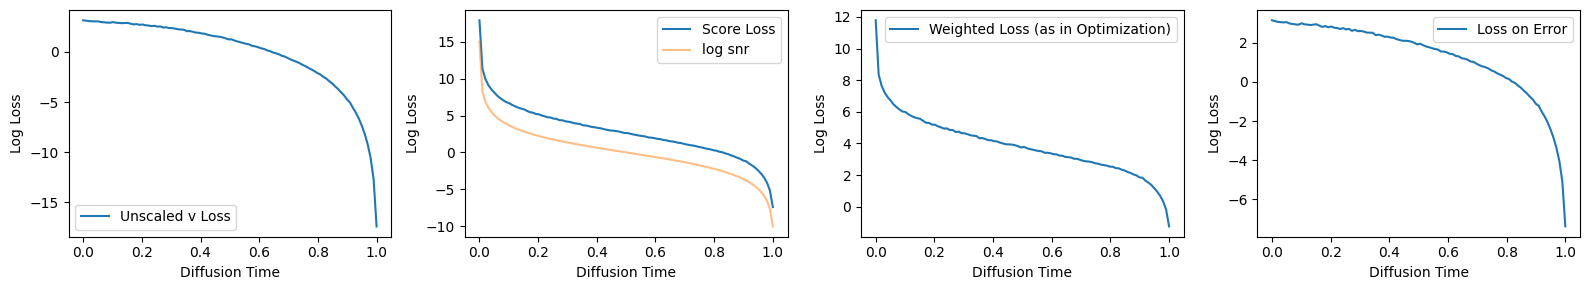

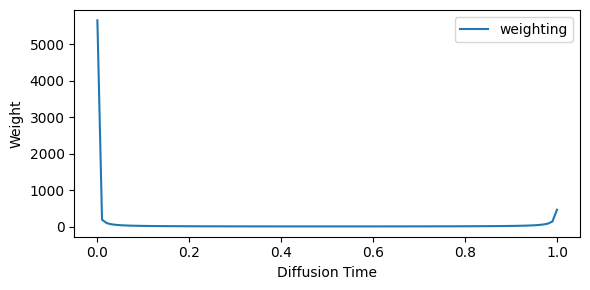

In [9]:
df_target = pd.DataFrame(loss_list_target.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_error_w_global = pd.DataFrame(loss_list_error_w_global.items(), columns=['Time', 'Loss'])
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])

# compute snr
snr = score_model.sde.get_snr(diffusion_time).cpu()
#upper_bound_loss = (np.sqrt(2) + 1) / (std.numpy()**2)

fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_target['Time'], np.log(df_target['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
#ax[1].plot(df_score['Time'], df_score['Loss'] / upper_bound_loss, label='Score Loss')
ax[1].plot(diffusion_time.cpu(), snr, label='log snr', alpha=0.5)
ax[2].plot(df_error_w_global['Time'], np.log(df_error_w_global['Loss']), label='Weighted Loss (as in Optimization)')
ax[3].plot(df_error['Time'], np.log(df_error['Loss']), label='Loss on Error')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
plt.savefig(f'plots/{score_model.name}/losses_diffusion_time.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(),
         weighting_function(diffusion_time, sde=score_model.sde, weighting_type=score_model.weighting_type,
                            prediction_type=score_model.prediction_type).cpu(),
         label='weighting')
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Validation

In [ ]:
data_size = 100  # number of observations
valid_prior_global, valid_data = generate_synthetic_data(prior, n_samples=100, data_size=data_size,
                                                         normalize=False, random_seed=0)
param_names = ['$D_{' + str(i+1) + '}$' for i in range(prior.D)]
n_post_samples = 100
score_model.current_number_of_obs = 1
score_model.sde.s_shift_cosine = 0

In [ ]:
visualize_simulation_output(valid_data)

In [ ]:
sample_posterior_single = lambda vd: sample_posterior(
    vd,
    prior_sigma=prior.scale,
    sigma=prior.simulator.scale,
    n_samples=n_post_samples
)
posterior_global_samples_true = np.array([sample_posterior_single(vd) for vd in valid_data])

In [ ]:
diagnostics.recovery(posterior_global_samples_true, np.array(valid_prior_global), variable_names=param_names)
diagnostics.calibration_ecdf(posterior_global_samples_true, np.array(valid_prior_global),
                             difference=True, variable_names=param_names);

In [ ]:
mini_batch_size = 10
t1_value = mini_batch_size /( data_size //score_model.current_number_of_obs)
t0_value = 1
mini_batch_arg = {
    'size': mini_batch_size,
    #'damping_factor': lambda t: t1_value + (t0_value - t1_value) * 0.5 * (1 + torch.cos(torch.pi * t)),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * score_model.sde.kernel(log_snr=score_model.sde.get_snr(t))[1],
    'damping_factor': lambda t: 0.1, #t1_value,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * torch.sigmoid(20*(t-0.3))
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

In [ ]:
posterior_global_samples_valid = langevin_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                   mini_batch_arg=mini_batch_arg,
                                                   diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler{score_model.current_number_of_obs}.png')

In [ ]:
posterior_global_samples_valid = sde_sampling(score_model, valid_data, n_post_samples=n_post_samples, diffusion_steps=300,
                                              method=['euler', 'milstein_grad_free', 'srk1w1'][1],
                                           device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler{score_model.current_number_of_obs}.png')

In [ ]:
posterior_global_samples_valid = sde_sampling(score_model, valid_data, n_post_samples=n_post_samples, diffusion_steps=100,
                                              method=['euler', 'milstein_grad_free', 'srk1w1'][1],
                                              mini_batch_arg=mini_batch_arg,
                                              device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler{score_model.current_number_of_obs}.png')

In [ ]:
mini_batch_size = 10
t1_value = 0.01 #mini_batch_size /( data_size //score_model.current_number_of_obs)
t0_value = 1
mini_batch_arg = {
    'size': mini_batch_size,
    #'damping_factor': lambda t: t1_value + (t0_value - t1_value) * 0.5 * (1 + torch.cos(torch.pi * t)),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * score_model.sde.kernel(log_snr=score_model.sde.get_snr(t))[1],
    'damping_factor': lambda t: torch.ones_like(t)*0.1, #t1_value,
    'damping_factor_prior': lambda t: torch.ones_like(t)*0.1, #t1_value,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor_prior': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * torch.sigmoid(20*(t-0.3))
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

In [ ]:
posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                   mini_batch_arg=mini_batch_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.z_score_contraction(posterior_global_samples_valid, np.array(valid_prior_global),
                                            variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/z_score_global_adaptive_sampler{score_model.current_number_of_obs}.png')

diagnostics.calibration_error(posterior_global_samples_valid, np.array(valid_prior_global))['values'].mean()

In [ ]:
posterior_global_samples_valid = probability_ode_solving(score_model, valid_data, n_post_samples=n_post_samples,
                                                         #run_sampling_in_parallel=False,
                                                         method=['RK45', 'RK23', 'Radau', 'LSODA'][0],
                                                         device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_ode{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode{score_model.current_number_of_obs}.png')

# Step Size for different Grid Sizes

- we compare score model with only one condition, and with $k$-conditions
- we show that the scaling in the number of needed sampling steps only depends on the Bayesian Units used
- error reduces when using more conditions, but since network size stays the same, increases at some point again
- we show how mini batching effects the posterior

Metrics:
- MMD between true and estimated posterior samples
- RMSE between the medians of true and estimated posterior samples
- Posterior contraction: (1 - var_empirical_posterior / var_prior) / (1 - var_true_posterior / var_prior), and using the mean variances over all parameters

In [10]:
def gaussian_kernel(x, y, sigma):
    """Compute Gaussian kernel between two sets of samples."""
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    sq_dists = np.sum((x[:, None, :] - y[None, :, :]) ** 2, axis=2)
    return np.exp(-sq_dists / (2 * sigma ** 2))

def compute_mmd(x, y, sigma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples.

    Args:
        x (np.ndarray): Samples from distribution P, shape (n, d).
        y (np.ndarray): Samples from distribution Q, shape (m, d).
        sigma (float): Bandwidth for the Gaussian kernel.

    Returns:
        float: Estimated MMD^2 value.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute kernel matrices
    K_xx = gaussian_kernel(x, x, sigma)
    K_yy = gaussian_kernel(y, y, sigma)
    K_xy = gaussian_kernel(x, y, sigma)

    # Compute MMD^2
    mmd_squared = (np.mean(K_xx) + np.mean(K_yy) - 2 * np.mean(K_xy))
    return mmd_squared


def kl_divergence(x, samples_q):
    mu_p, std_p = analytical_posterior_mean_std(x, prior_std=prior.scale, likelihood_std=prior.simulator.scale)
    cov_p = np.diag(std_p**2)

    mu_q = np.mean(samples_q, axis=0)
    cov_q = np.cov(samples_q, rowvar=False)

    d = mu_p.shape[0]
    cov_q_inv = np.linalg.inv(cov_q)

    term1 = np.log(np.linalg.det(cov_q) / np.linalg.det(cov_p))
    term2 = np.trace(cov_q_inv @ cov_p)
    term3 = (mu_q - mu_p).T @ cov_q_inv @ (mu_q - mu_p)

    return 0.5 * (term1 - d + term2 + term3)

In [23]:
# Ensure we generate enough synthetic data samples.
n_samples_data = 100
n_post_samples = 100
score_model.current_number_of_obs = 1
max_steps = 10000
variable_of_interest = ['mini_batch', #'n_conditions',
                        'cosine_shift', 'damping_factor', 'damping_factor_prior', 'damping_factor_t'][4]


#for variable_of_interest in ['mini_batch']:#['mini_batch', 'cosine_shift', 'damping_factor', 'damping_factor_prior', 'damping_factor_t'][::-1]:
mini_batch = [None]
n_conditions = [1]
cosine_shifts = [2]
d_factors = [1]  # using the d factor depending on the mini batch size

if variable_of_interest == 'mini_batch':
    # Set up your data sizes and mini-batch parameters.
    data_sizes = np.array([1, 10, 100, 1000, 10000])
    mini_batch = [1, 10, 100, 1000, 10000, None]
    second_variable_of_interest = 'data_size'

elif variable_of_interest == 'n_conditions':
    # Set up your data sizes and mini-batch parameters.
    data_sizes = np.array([1, 10, 100, 1000, 10000, 100000])
    n_conditions = [1, 5, 10, 20, 50, 100]
    second_variable_of_interest = 'data_size'

elif variable_of_interest == 'cosine_shift':
    # Set up your data sizes and mini-batch parameters.
    data_sizes = np.array([1, 10, 100, 1000, 10000])
    mini_batch = [10]
    cosine_shifts = [0, -1, 1, 2, 5, 10]
    second_variable_of_interest = 'data_size'

elif variable_of_interest in ['damping_factor', 'damping_factor_prior', 'damping_factor_t']:
    # Set up your data sizes and mini-batch parameters.
    data_sizes = np.array([10, 100, 1000, 10000, 100000])
    mini_batch = [10]
    d_factors = [0.001, 0.01, 0.1, 0.5, 0.75, 0.9, 1]
    second_variable_of_interest = 'data_size'
else:
    raise ValueError('Unknown variable_of_interest')

df_path = f'plots/{score_model.name}/df_results_{variable_of_interest}.csv'
if os.path.exists(df_path):
    # Load CSV
    df_results = pd.read_csv(df_path, index_col=0)
    # Convert string representations back to lists
    df_results['list_steps'] = df_results['list_steps'].apply(lambda x: ast.literal_eval(x))

    if variable_of_interest == 'damping_factor_prior':
        df_results['damping_factor_prior'] = df_results['damping_factor']
    elif variable_of_interest == 'damping_factor_t':
        df_results['damping_factor_t'] = df_results['damping_factor']
else:
    df_results = None

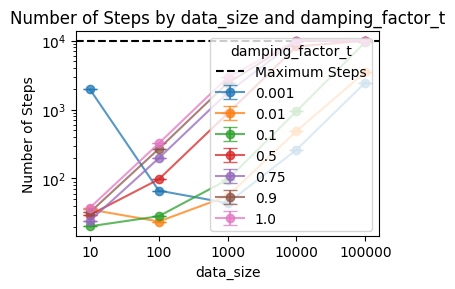

In [24]:
# Group by both second_variable_of_interest and variable_of_interest to compute mean and standard deviation of n_steps.
grouped_bar = df_results.groupby([second_variable_of_interest, variable_of_interest])['n_steps'].agg(['mean','std']).reset_index()

# Determine unique second_variable_of_interest and variable_of_interest values.
second_variable_of_interest_values = sorted(grouped_bar[second_variable_of_interest].unique())
variable_batch_values = sorted(grouped_bar[variable_of_interest].unique())

# Set up errorbar plot parameters.
n_groups = len(second_variable_of_interest_values)
n_series = len(variable_batch_values)
x = np.arange(n_groups)  # base x locations for groups

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)

# Plot an errorbar for each variable_of_interest value within each second_variable_of_interest group.
for i, mb in enumerate(variable_batch_values):
    subset = grouped_bar[grouped_bar[variable_of_interest] == mb]
    means = []
    stds = []
    for ds in second_variable_of_interest_values:
        row = subset[subset[second_variable_of_interest] == ds]
        if not row.empty:
            means.append(row['mean'].values[0])
            stds.append(row['std'].values[0])
        else:
            means.append(np.nan)
            stds.append(0)

    # Use 'o-' for markers connected by lines.
    ax.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75)

ax.axhline(max_steps, label='Maximum Steps', color='k', linestyle='--')

# Center the x-axis ticks and label them.
ax.set_xticks(x)
ax.set_xticklabels(second_variable_of_interest_values)
ax.set_xlabel(second_variable_of_interest)
ax.set_ylabel('Number of Steps')
ax.set_title(f'Number of Steps by {second_variable_of_interest} and {variable_of_interest}')
ax.set_yscale('log')
ax.legend(title=variable_of_interest)

plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_n_steps.png')
plt.show()

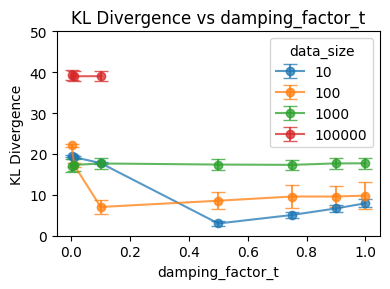

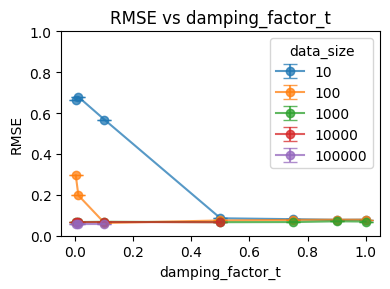

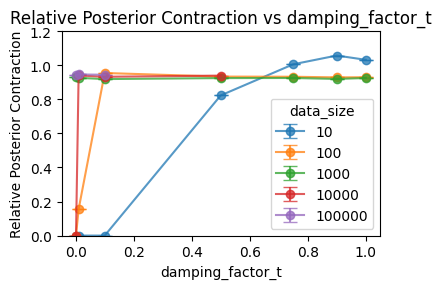

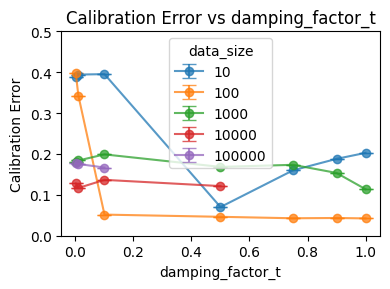

In [25]:
if variable_batch_values == 'mini_batch_size':
    # ------------------------------
    # Plot 1: Bar plot of n_steps for the full-batch  case.
    # ------------------------------

    # Filter the full-batch rows
    df_full = df_results[df_results['data_size'] == df_results['mini_batch']]

    # Group by data_size and compute mean and standard deviation of n_steps.
    grouped_full = df_full.groupby('data_size')['n_steps'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(4, 3), tight_layout=True)
    plt.bar(grouped_full['data_size'], grouped_full['mean'],
            yerr=grouped_full['std'], capsize=5, color='skyblue', edgecolor='black')
    plt.xlabel('Data Size')
    plt.ylabel('Number of Steps')
    plt.title('Number of Steps (Full Batch) per Data Size')
    plt.xticks(grouped_full['data_size'])
    plt.yscale('log')
    plt.xscale('log')
    plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_steps_full_batch.png')
    plt.show()

# ------------------------------
# Plot 2: Errorbar plots for MMD, RMSE, and Contraction vs. variable_of_interest.
# ------------------------------

# Filter rows with a variable_of_interest value (skip full-batch rows).
df_mb = df_results[df_results[variable_of_interest].notnull()].copy()
# Convert mini_batch to float (if not already) to allow proper plotting on the x-axis.
df_mb[variable_of_interest] = df_mb[variable_of_interest].astype(float)

# Define the metrics to plot: key is dataframe column, value is label for y-axis.
metrics = {
    'kl': 'KL Divergence',
    #'mmd': 'MMD',
    'median_rmse': 'RMSE',
    'rel_contraction': 'Relative Posterior Contraction',
    'c_error': 'Calibration Error'
}

y_limits = {
    'kl': (0, 50),
    'median_rmse': (0, 1),
    'rel_contraction': (0, 1.2),
    'c_error': (0, 0.5)
}

# Identify the unique data sizes (to plot different lines per data size).
unique_second_variable_of_interest = sorted(df_mb[second_variable_of_interest].unique())

# Create one figure per metric.
for metric, metric_label in metrics.items():
    plt.figure(figsize=(4, 3), tight_layout=True)
    for ds in unique_second_variable_of_interest:
        # Select the rows for this particular data size.
        df_sub = df_mb[(df_mb[second_variable_of_interest] == ds) & (df_mb['n_steps'] != max_steps)]
        # Group by variable_of_interest size to get mean and std of the metric.
        grouped = df_sub.groupby(variable_of_interest)[metric].agg(['mean', 'std']).reset_index()
        if not np.isfinite(grouped['mean']).all() or grouped.empty:
            continue
        plt.errorbar(grouped[variable_of_interest], grouped['mean'], yerr=grouped['std'],
                     marker='o', capsize=5, label=f'{ds}', alpha=0.75)
    plt.xlabel(variable_of_interest)
    plt.ylabel(metric_label)
    plt.title(f'{metric_label} vs {variable_of_interest}')
    plt.legend(title=second_variable_of_interest)
    # Using a logarithmic scale for the x-axis since mini-batch sizes vary widely.
    if variable_of_interest == 'mini_batch':
        plt.xscale('log')
    #if metric == 'rel_contraction':
    #    plt.ylim(0, 1.2)
    plt.ylim(y_limits[metric])
    plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_{metric}.png')
    plt.show()

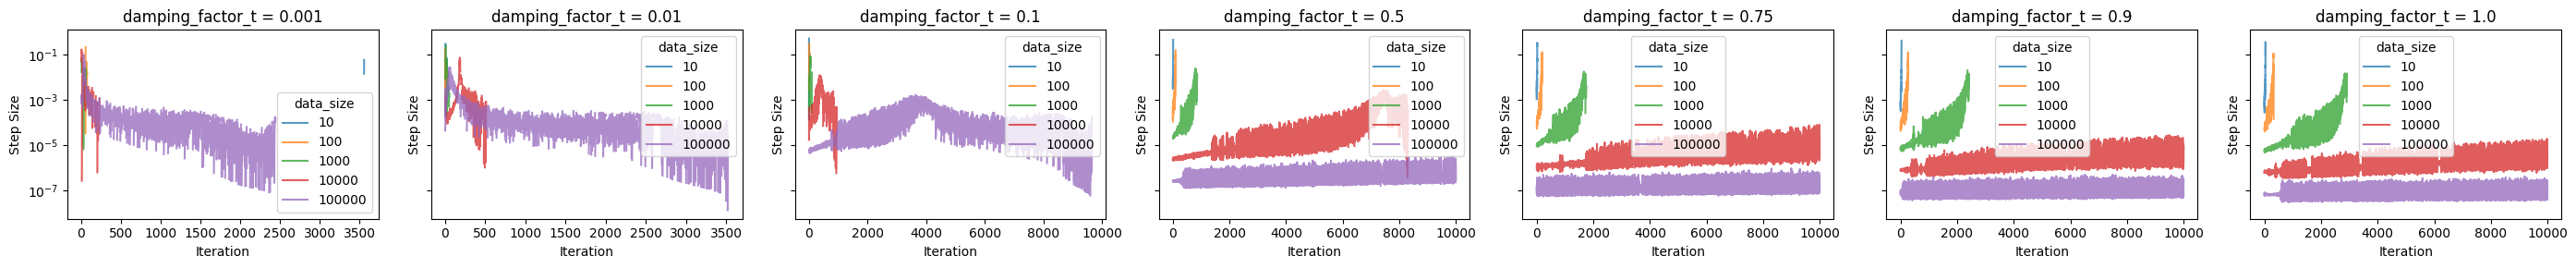

In [26]:
if variable_of_interest == 'mini_batch':
    # Figure 1: Full Batch (mini_batch is None) for data_id 0
    # ------------------------------
    # Filter for valid_id 0 and full-batch runs
    df_full = df_results[(df_results['data_id'] == 0) & (df_results['data_size'] == df_results['mini_batch'])]

    plt.figure(figsize=(4, 3), tight_layout=True)
    for ds in sorted(df_full['data_size'].unique()):
        # Extract the row for this data_size (should be a single row per combination)
        row = df_full[df_full['data_size'] == ds]
        if not row.empty:
            # Extract the list of step sizes (assumed to be a list or array)
            steps_list = row.iloc[0]['list_steps']
            # Plot step size vs iteration
            plt.plot(range(len(steps_list)), steps_list, label=f"{ds}", alpha=.75)

    plt.xlabel("Iteration")
    plt.ylabel("Step Size")
    plt.yscale('log')
    plt.title("Step Size Over Time for Full Batch")
    plt.legend(title="Data Size")
    plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_full_batch_step_size.png')
    plt.show()

# ------------------------------
# Figure 2
# ------------------------------
# Filter for data_id 0 and only mini-batch runs.
df_mb = df_results[(df_results['data_id'] == 0) & (df_results[variable_of_interest].notnull())]

# Get the sorted unique mini_batch values
variable_batch_values = sorted(df_mb[variable_of_interest].unique())
n_subplots = len(variable_batch_values)

# Create subplots (one per mini_batch value)
fig, axes = plt.subplots(1, n_subplots, figsize=(4 * n_subplots, 3), sharey=True, tight_layout=True)

# In case there's only one subplot, wrap axes in a list for uniformity.
if n_subplots == 1:
    axes = [axes]

for ax, mb in zip(axes, variable_batch_values):
    # Filter for the current mini_batch value
    df_mb_subset = df_mb[df_mb[variable_of_interest] == mb]
    for ds in sorted(df_mb_subset[second_variable_of_interest].unique()):
        row = df_mb_subset[df_mb_subset[second_variable_of_interest] == ds]
        if not row.empty:
            steps_list = row.iloc[0]['list_steps']
            ax.plot(range(len(steps_list)), steps_list, label=f"{ds}", alpha=.75)

    ax.set_title(f"{variable_of_interest} = {mb}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Step Size")
    ax.set_yscale('log')
    ax.legend(title=second_variable_of_interest)
plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_step_size.png')
plt.show()